In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import glob

In [3]:
!ls /content/drive/MyDrive/Colab_Notebooks/Images/stamp_samples

00006-2554435554.png  00133-2554435681.png  00697-865005268.png
00023-2554435571.png  00149-2554435697.png  00955-865005526.png
00026-2554435574.png  00157-2554435705.png  00982-865005553.png
00036-2554435584.png  00293-202581919.png   01048-865005619.png
00045-2554435593.png  00297-202581923.png   01053-865005624.png
00065-2554435613.png  00498-865005069.png   01059-865005630.png
00068-2554435616.png  00512-865005083.png   01086-865005657.png
00078-2554435626.png  00602-865005173.png   01109-865005680.png
00091-2554435639.png  00620-865005191.png   01117-865005688.png
00092-2554435640.png  00636-865005207.png   01200-865005771.png


In [4]:
SCANS_DIR = "/content/drive/MyDrive/Colab_Notebooks/Images/stamp_samples/"
image_paths = glob.glob(SCANS_DIR + '*.png')
image_paths = sorted(image_paths)
len(image_paths)

30

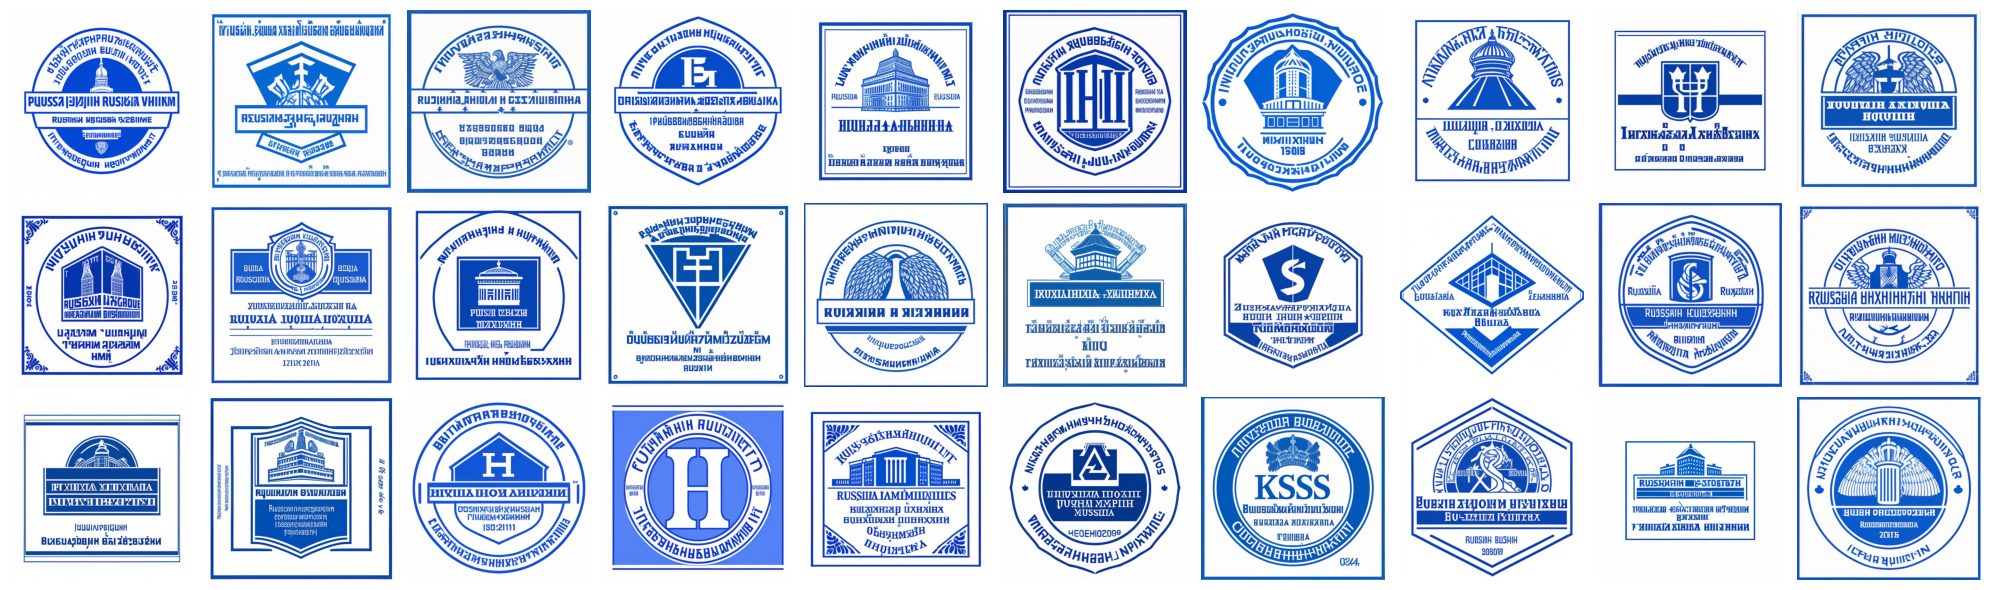

<Figure size 640x480 with 0 Axes>

In [5]:
import matplotlib
import matplotlib.pyplot as plt

from PIL import Image

fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 6))

for i, path in enumerate(image_paths):
    img = Image.open(path)
    ax = axes[i // 10, i % 10]
    ax.axis('off')
    ax.imshow(img)

plt.tight_layout()
plt.show()
plt.savefig("original_stamps.png")

In [6]:
import cv2
import numpy as np
import random
import os

def apply_geometric_transformations(image):
    rows, cols = image.shape[:2]
    M = cv2.getRotationMatrix2D((cols/2, rows/2), random.uniform(-30, 30), 1)
    image = cv2.warpAffine(image, M, (cols, rows))
    image = cv2.resize(image, (int(cols * random.uniform(0.8, 1.2)), int(rows * random.uniform(0.8, 1.2))))
    return image

def add_noise(image):
    noise_type = random.choice(["gaussian", "salt_and_pepper", "speckle"])
    if noise_type == "gaussian":
        noise = np.random.normal(0, 1, image.shape).astype(np.uint8)
        image = cv2.add(image, noise)
    elif noise_type == "salt_and_pepper":
        salt_vs_pepper = 0.5
        noise = np.zeros(image.shape, np.uint8)
        salt = np.random.randint(0, int(255 * salt_vs_pepper), image.shape)
        pepper = np.random.randint(int(255 * (1 - salt_vs_pepper)), 255, image.shape)
        noise[salt == 255] = 255
        noise[pepper == 0] = 0
        image = cv2.add(image, noise)
    elif noise_type == "speckle":
        noise = np.random.normal(0, 1, image.shape).astype(np.uint8)
        image = image + image * noise
    return image

def apply_blurring(image):
    blur_type = random.choice(["gaussian", "median"])
    if blur_type == "gaussian":
        image = cv2.GaussianBlur(image, (5, 5), 0)
    elif blur_type == "median":
        image = cv2.medianBlur(image, 5)
    return image

def adjust_contrast(image):
    alpha = random.uniform(0.7, 1.3)
    beta = random.uniform(-50, 50)
    image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return image

def shuffle_color_channels(image):
    channels = list(cv2.split(image))
    random.shuffle(channels)
    image = cv2.merge(channels)
    return image

def apply_distortions(image_paths, output_path):
    distorted_images = []

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    for path in image_paths:
        image = cv2.imread(path)

        image = apply_geometric_transformations(image)
        image = add_noise(image)
        image = apply_blurring(image)
        image = adjust_contrast(image)
        image = shuffle_color_channels(image)

        filename = os.path.basename(path)
        output_filename = os.path.join(output_path, filename.split(".")[0] + ".png")
        cv2.imwrite(output_filename, image)

        distorted_images.append(output_filename)

    return distorted_images


output_path = "/content/drive/MyDrive/Colab_Notebooks/Images/stamp_distorted_samples/"
distorted_images = apply_distortions(image_paths, output_path)

In [7]:
len(distorted_images)

30

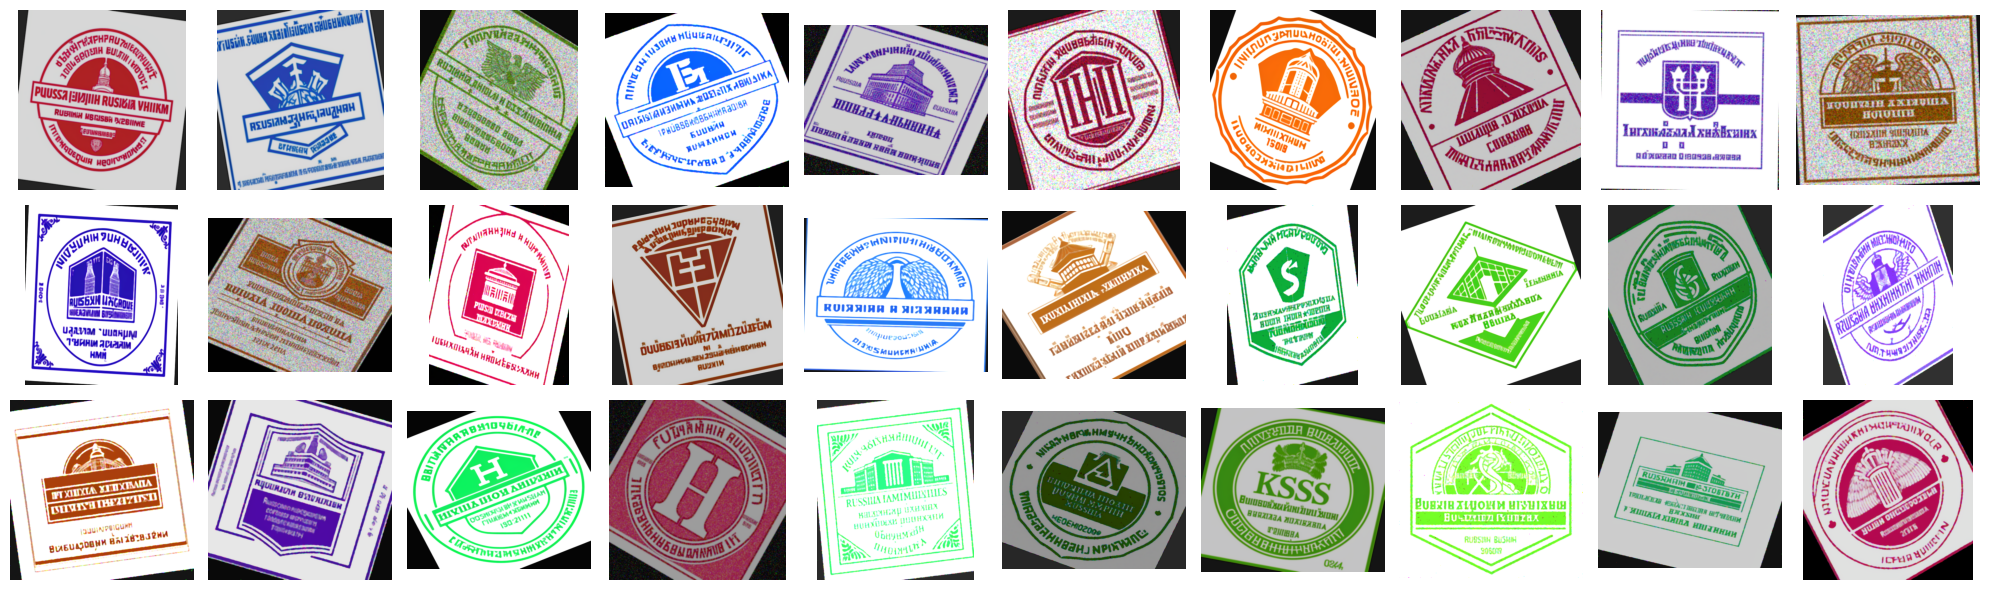

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt
from PIL import Image

fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(20, 6))

for i, path in enumerate(distorted_images):
    img = Image.open(path)
    ax = axes[i // 10, i % 10]
    ax.axis('off')
    ax.imshow(img)

plt.tight_layout()
plt.show()
plt.savefig("distorted_stamps.png")

In [9]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

def extract_image_embedding(img_path, model):
    img = image.load_img(img_path)
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    features = model.predict(img_array)
    embedding = features.flatten()
    return embedding

In [10]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19

vgg19_model = VGG19(weights='imagenet', include_top=False)

VGG19_embeddings = []
VGG19_distorted_embeddings = []

for path in image_paths:
    embedding = extract_image_embedding(path, vgg19_model);
    VGG19_embeddings.append(embedding)

for path in distorted_images:
    embedding = extract_image_embedding(path, vgg19_model);
    VGG19_distorted_embeddings.append(embedding)

print("VGG19 Image embeddings:")
print(VGG19_embeddings[0])
print(VGG19_distorted_embeddings[0])

1/1 [==============================] - 1s 916ms/step
VGG19 Image embeddings:
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [11]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception

xception_model = Xception(weights='imagenet', include_top=False)

Xception_embeddings = []
Xception_distorted_embeddings = []

for path in image_paths:
    embedding = extract_image_embedding(path, xception_model);
    Xception_embeddings.append(embedding)

for path in distorted_images:
    embedding = extract_image_embedding(path, xception_model);
    Xception_distorted_embeddings.append(embedding)

print("Xception Image embeddings:")
print(Xception_embeddings[0])
print(Xception_distorted_embeddings[0])

1/1 [==============================] - 0s 199ms/step
Xception Image embeddings:
[ 0.        0.       22.446863 ...  0.        0.        0.      ]
[0.         3.7269783  9.451773   ... 0.         0.18034023 0.        ]


In [12]:
import tensorflow as tf
from tensorflow.keras.applications.resnet_v2 import ResNet152V2, ResNet50V2, ResNet101V2

# ResNet50V2
resnet50v2_model = ResNet50V2(weights='imagenet', include_top=False)
ResNet50V2_embeddings = []
ResNet50V2_distorted_embeddings = []

for path in image_paths:
    embedding = extract_image_embedding(path, resnet50v2_model);
    ResNet50V2_embeddings.append(embedding)

for path in distorted_images:
    embedding = extract_image_embedding(path, resnet50v2_model);
    ResNet50V2_distorted_embeddings.append(embedding)

print("ResNet50V2 Image embeddings:")
print(ResNet50V2_embeddings[0])
print(ResNet50V2_distorted_embeddings[0])


# ResNet101V2
resnet101v2_model = ResNet101V2(weights='imagenet', include_top=False)
ResNet101V2_embeddings = []
ResNet101V2_distorted_embeddings = []

for path in image_paths:
    embedding = extract_image_embedding(path, resnet101v2_model);
    ResNet101V2_embeddings.append(embedding)

for path in distorted_images:
    embedding = extract_image_embedding(path, resnet101v2_model);
    ResNet101V2_distorted_embeddings.append(embedding)

print("ResNet101V2 Image embeddings:")
print(ResNet101V2_embeddings[0])
print(ResNet101V2_distorted_embeddings[0])

# ResNet152V2
resnet152v2_model = ResNet152V2(weights='imagenet', include_top=False)
ResNet152V2_embeddings = []
ResNet152V2_distorted_embeddings = []

for path in image_paths:
    embedding = extract_image_embedding(path, resnet152v2_model);
    ResNet152V2_embeddings.append(embedding)

for path in distorted_images:
    embedding = extract_image_embedding(path, resnet152v2_model);
    ResNet152V2_distorted_embeddings.append(embedding)

print("ResNet152V2 Image embeddings:")
print(ResNet152V2_embeddings[0])
print(ResNet152V2_distorted_embeddings[0])

1/1 [==============================] - 0s 154ms/step
ResNet50V2 Image embeddings:
[69.50249  87.074554 86.12188  ...  0.        0.        0.      ]
[1163.0985     0.       162.55376 ...    0.         0.         0.     ]
1/1 [==============================] - 0s 464ms/step
ResNet101V2 Image embeddings:
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]
1/1 [==============================] - 0s 426ms/step
ResNet152V2 Image embeddings:
[  0.      106.93304   0.      ... 218.62216 279.4445  139.92311]
[  0.       190.01717   54.512253 ... 100.304535  74.19196   71.18463 ]


In [13]:
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = InceptionV3(weights='imagenet', include_top=False)

InceptionV3_embeddings = []
InceptionV3_distorted_embeddings = []

for path in image_paths:
    embedding = extract_image_embedding(path, inceptionv3_model);
    InceptionV3_embeddings.append(embedding)

for path in distorted_images:
    embedding = extract_image_embedding(path, inceptionv3_model);
    InceptionV3_distorted_embeddings.append(embedding)

print("InceptionV3 Image embeddings:")
print(InceptionV3_embeddings[0])
print(InceptionV3_distorted_embeddings[0])

1/1 [==============================] - 0s 130ms/step
InceptionV3 Image embeddings:
[0. 0. 0. ... 0. 0. 0.]
[22.91397   0.        0.       ...  0.       16.969292  0.      ]


In [14]:
import tensorflow as tf
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

inceptionresnetv2_model = InceptionResNetV2(weights='imagenet', include_top=False)

InceptionResNetV2_embeddings = []
InceptionResNetV2_distorted_embeddings = []

for path in image_paths:
    embedding = extract_image_embedding(path, inceptionresnetv2_model);
    InceptionResNetV2_embeddings.append(embedding)

for path in distorted_images:
    embedding = extract_image_embedding(path, inceptionresnetv2_model);
    InceptionResNetV2_distorted_embeddings.append(embedding)

print("InceptionResNetV2 Image embeddings:")
print(InceptionResNetV2_embeddings[0])
print(InceptionResNetV2_distorted_embeddings[0])

1/1 [==============================] - 0s 475ms/step
InceptionResNetV2 Image embeddings:
[  0.        0.        0.      ...  22.87892 143.7887   76.18239]
[  0.         0.         0.       ...  28.378452 132.54132   82.47408 ]


In [15]:
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import MobileNet

mobilenet_model = MobileNet(weights='imagenet', include_top=False)

MobileNet_embeddings = []
MobileNet_distorted_embeddings = []

for path in image_paths:
    embedding = extract_image_embedding(path, mobilenet_model);
    MobileNet_embeddings.append(embedding)

for path in distorted_images:
    embedding = extract_image_embedding(path, mobilenet_model);
    MobileNet_distorted_embeddings.append(embedding)

print("MobileNet Image embeddings:")
print(MobileNet_embeddings[0])
print(MobileNet_distorted_embeddings[0])

1/1 [==============================] - 0s 54ms/step
MobileNet Image embeddings:
[0. 0. 0. ... 0. 0. 0.]
[0. 0. 0. ... 0. 0. 0.]


In [16]:
import tensorflow as tf
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
import numpy as np

# DenseNet121
densenet121_model = DenseNet121(weights='imagenet', include_top=False)
DenseNet121_embeddings = []
DenseNet121_distorted_embeddings = []

for path in image_paths:
    embedding = extract_image_embedding(path, densenet121_model);
    DenseNet121_embeddings.append(embedding)

for path in distorted_images:
    embedding = extract_image_embedding(path, densenet121_model);
    DenseNet121_distorted_embeddings.append(embedding)

print("DenseNet121 Image embeddings:")
print(DenseNet121_embeddings[0])
print(DenseNet121_distorted_embeddings[0])

# DenseNet169
densenet169_model = DenseNet169(weights='imagenet', include_top=False)
DenseNet169_embeddings = []
DenseNet169_distorted_embeddings = []

for path in image_paths:
    embedding = extract_image_embedding(path, densenet169_model);
    DenseNet169_embeddings.append(embedding)

for path in distorted_images:
    embedding = extract_image_embedding(path, densenet169_model);
    DenseNet169_distorted_embeddings.append(embedding)

print("DenseNet169 Image embeddings:")
print(DenseNet169_embeddings[0])
print(DenseNet169_distorted_embeddings[0])

# DenseNet201
densenet201_model = DenseNet201(weights='imagenet', include_top=False)
DenseNet201_embeddings = []
DenseNet201_distorted_embeddings = []

for path in image_paths:
    embedding = extract_image_embedding(path, densenet201_model);
    DenseNet201_embeddings.append(embedding)

for path in distorted_images:
    embedding = extract_image_embedding(path, densenet201_model);
    DenseNet201_distorted_embeddings.append(embedding)

print("DenseNet201 Image embeddings:")
print(DenseNet201_embeddings[0])
print(DenseNet201_distorted_embeddings[0])

1/1 [==============================] - 0s 158ms/step
DenseNet121 Image embeddings:
[0.        0.        0.        ... 0.        2.5888052 7.9350963]
[0.       0.       0.       ... 0.       9.139972 0.      ]
1/1 [==============================] - 0s 185ms/step
DenseNet169 Image embeddings:
[0.         0.00869367 0.         ... 0.         0.         0.        ]
[0.03055235 0.         0.         ... 0.         0.         0.        ]
1/1 [==============================] - 0s 228ms/step
DenseNet201 Image embeddings:
[0.        0.        0.        ... 1.0140615 0.        0.       ]
[0.        0.        0.        ... 1.4629458 0.        1.950094 ]


In [17]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0
import numpy as np

efficientnetb0_model = EfficientNetB0(weights='imagenet', include_top=False)

EfficientNet_embeddings = []
EfficientNet_distorted_embeddings = []

for path in image_paths:
    embedding = extract_image_embedding(path, efficientnetb0_model)
    EfficientNet_embeddings.append(embedding)

for path in distorted_images:
    embedding = extract_image_embedding(path, efficientnetb0_model)
    EfficientNet_distorted_embeddings.append(embedding)

print("EfficientNet Image embeddings:")
print(EfficientNet_embeddings[0])
print(EfficientNet_distorted_embeddings[0])

1/1 [==============================] - 0s 77ms/step
EfficientNet Image embeddings:
[ 0.16534722 -0.02658048 -0.14386804 ... -0.2747324  -0.26256388
  0.5666046 ]
[ 0.5171546  -0.02192746 -0.16456132 ... -0.16184449  1.5587149
  0.30836466]


In [18]:
import numpy as np
from scipy.spatial.distance import cosine

models = ["VGG19", "Xception", "ResNet50V2", "ResNet101V2", "ResNet152V2",
          "InceptionV3", "InceptionResNetV2", "MobileNet", "DenseNet121",
          "DenseNet169", "DenseNet201", "EfficientNet"]

similarities = {}
for model in models:
    embeddings = eval(f"{model}_embeddings")
    distorted_embeddings = eval(f"{model}_distorted_embeddings")

    model_similarities = []
    for emb1, emb2 in zip(embeddings, distorted_embeddings):
        similarity = 1 - cosine(emb1, emb2)
        model_similarities.append(similarity)

    similarities[model] = model_similarities

avg_similarities = {}
for model in models:
    model_avg_similarity = np.mean(similarities[model])
    avg_similarities[model] = model_avg_similarity

best_model = max(avg_similarities, key=avg_similarities.get)

for model in models:
    print(f"{model}: {avg_similarities[model]}")

print("\nBest Model:", best_model)

VGG19: 0.49011854181687037
Xception: 0.6507189601659775
ResNet50V2: 0.5520255992809932
ResNet101V2: 0.680689827601115
ResNet152V2: 0.8937572995821635
InceptionV3: 0.5793440481026967
InceptionResNetV2: 0.9882085382938385
MobileNet: 0.4855784465869268
DenseNet121: 0.6840450406074524
DenseNet169: 0.6224782675504684
DenseNet201: 0.6082567612330119
EfficientNet: 0.5038080468773842

Best Model: InceptionResNetV2


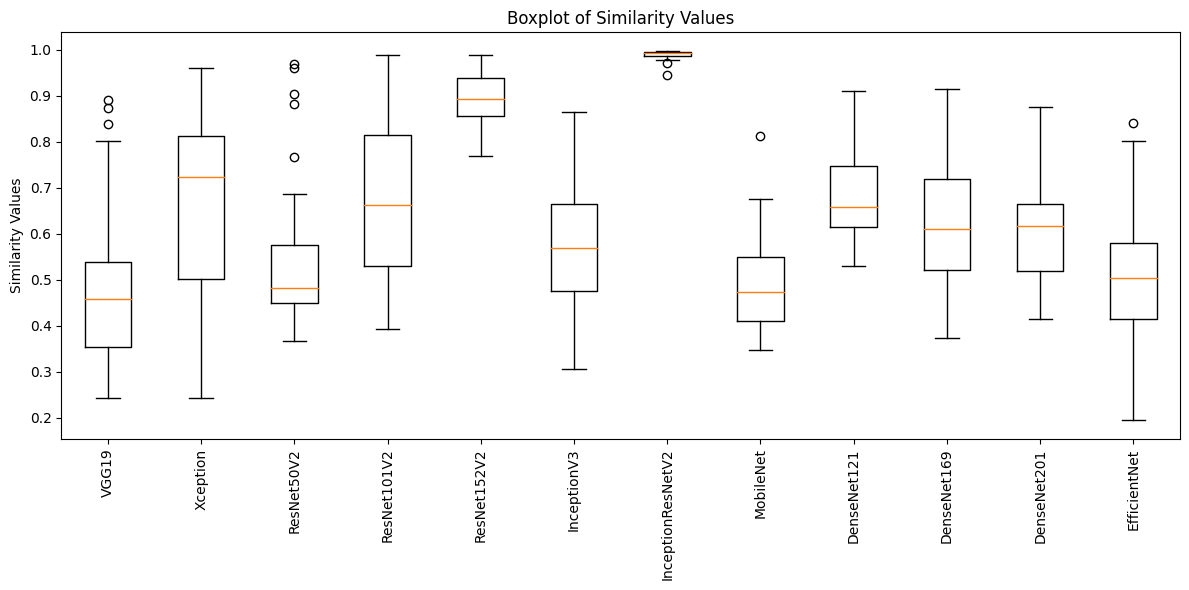

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt

models = ["VGG19", "Xception", "ResNet50V2", "ResNet101V2", "ResNet152V2",
          "InceptionV3", "InceptionResNetV2", "MobileNet", "DenseNet121",
          "DenseNet169", "DenseNet201", "EfficientNet"]

similarities = {}
for model in models:
    embeddings = eval(f"{model}_embeddings")
    distorted_embeddings = eval(f"{model}_distorted_embeddings")

    model_similarities = []
    for emb1, emb2 in zip(embeddings, distorted_embeddings):
        similarity = 1 - cosine(emb1, emb2)
        model_similarities.append(similarity)

    similarities[model] = model_similarities

all_similarities = [similarities[model] for model in models]

plt.figure(figsize=(12, 6))
plt.boxplot(all_similarities, labels=models)
plt.xticks(rotation=90)
plt.ylabel("Similarity Values")
plt.title("Boxplot of Similarity Values")
plt.tight_layout()
plt.show()
plt.savefig("statistical_analysis.png")